<a href="https://colab.research.google.com/github/SAR2652/BBC-News-Text-Summarization/blob/main/BBC_News_Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News Text Summarization

## Load Data

In [1]:
import tensorflow_datasets as tfds
from tqdm import tqdm
import pandas as pd
tqdm.pandas()

In [2]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load('multi_news', shuffle_files = True, split = ['train', 'validation', 'test'], with_info = True)

Metal device set to: Apple M1


2021-12-07 16:38:33.491962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-07 16:38:33.492193: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
df_train = tfds.as_dataframe(ds_train.take(-1), ds_info)
df_train.head()

2021-12-07 16:38:35.063428: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-07 16:38:35.063840: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


,document,summary
0,"b'Nicki Minaj attends the Harper\'s BAZAAR ""IC...",b'\xe2\x80\x93 Nicki Minaj and Cardi B were in...
1,"b'COLUMBIA, S.C. Federal authorities launched ...","b'\xe2\x80\x93 A police officer in Columbia, S..."
2,"b""In Brief \n \n San Francisco named top U.S....",b'\xe2\x80\x93 San Francisco has topped this y...
3,b'About 1 in 45 children in the United States ...,b'\xe2\x80\x93 A new report reveals what appea...
4,b'A day after allegations surfaced that Northa...,b'\xe2\x80\x93 The head coach and assistant co...


In [4]:
df_val = tfds.as_dataframe(ds_validation.take(-1), ds_info)
df_val.head()

,document,summary
0,b'CLOSE SportsPulse: NFL Insider Mike Jones po...,b'\xe2\x80\x93 The Kansas City Chiefs learned ...
1,b'Can\xe2\x80\x99t go to space? Try Idaho. Las...,b'\xe2\x80\x93 There are fewer than a dozen da...
2,"b'Oscar de la Renta was a great man, and a gre...",b'\xe2\x80\x93 Fashion designer and icon Oscar...
3,b'With his first trip abroad as president behi...,"b'\xe2\x80\x93 ""I think we hit a home run,"" Pr..."
4,"b'7 Gallery: Jessica Heeringa, missing from Ex...",b'\xe2\x80\x93 Jessica Heeringa was working th...


In [5]:
df_test = tfds.as_dataframe(ds_test.take(-1), ds_info)
df_test.head()

,document,summary
0,"b'Think back, everyone -- can you remember whe...",b'\xe2\x80\x93 No matter how much you like Jas...
1,"b""'Alien: Covenant': Film Review \n \n Michae...",b'\xe2\x80\x93 A spaceship arrives on a distan...
2,b'By REUTERS \n \n Photo: Reuters \n \n Char...,b'\xe2\x80\x93 France is on lockdown today aft...
3,b'These crawls are part of an effort to archiv...,"b""\xe2\x80\x93 Just when you thought the Repub..."
4,b'The estranged wife of acclaimed concert pian...,"b'\xe2\x80\x93 Sofya Tsygankova, the estranged..."


In [6]:
def decode_text(x):
    return x.decode('utf-8')

In [7]:
df_train.loc[:, 'document'] = df_train.loc[:, 'document'].progress_apply(decode_text)
df_train.loc[:, 'summary'] = df_train.loc[:, 'summary'].progress_apply(decode_text)
df_val.loc[:, 'document'] = df_val.loc[:, 'document'].progress_apply(decode_text)
df_val.loc[:, 'summary'] = df_val.loc[:, 'summary'].progress_apply(decode_text)
df_test.loc[:, 'document'] = df_test.loc[:, 'document'].progress_apply(decode_text)
df_test.loc[:, 'summary'] = df_test.loc[:, 'summary'].progress_apply(decode_text)

100%|███████████████████████████████████| 5622/5622 [00:00<00:00, 521320.68it/s]


## Prepare Environment for Development

## Extractive Text Summarization

### Import Necessary Libraries

In [8]:
import re, heapq, nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarvesh26/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sarvesh26/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Function for Extractive Summarization

In [9]:
def extractive_summarize(text):
    # Tokenization
    sentences = nltk.sent_tokenize(text)
    
    # Text preprocessing
    text = re.sub(r'\[[0-9]*\]', ' ', text) # remove numeric citations
    text = re.sub(r'\s+', ' ', text) # remove 1+ continuous whitespaces
    clean_text = text.lower() # convert all text to lower case
    clean_text = re.sub(r'\W', ' ', clean_text) # remove non-word characters
    clean_text = re.sub(r'\d', ' ', clean_text) # remove any digits
    clean_text = re.sub(r'\s+', ' ', clean_text) # remove 1+ continuous whitespaces

    # Generate dictionary of word frequencies while deleting stopwords
    stop_words = stopwords.words('english')
    word2count = {}
    for word in nltk.word_tokenize(clean_text):
        if word not in stop_words:
            if word not in word2count.keys(): # create new key as word
                word2count[word] = 1
            else:
                word2count[word] += 1

    # standardize all values
    for key in word2count.keys():
        word2count[key] = word2count[key] / max(word2count.values())

    # Generate information
    sent2score = {}
    for sentence in sentences:
        for word in nltk.word_tokenize(sentence.lower()):
            if word in word2count.keys():
                if len(sentence.split(' ')) < 30:   # sentence length condition
                    if sentence not in sent2score.keys():
                        sent2score[sentence] = word2count[word]
                    else:
                        sent2score[sentence] += word2count[word]

    # Select best sentences
    best_sentences = heapq.nlargest(5, sent2score, key = sent2score.get)
    print('----------------------------------------------------------------------------')
    for sentence in best_sentences:
        print(sentence)

### Test for Extractive Summarization

In [10]:
doc = df_val['document'].values[0]
doc

'CLOSE SportsPulse: NFL Insider Mike Jones ponders why it took a TMZ video for the Chiefs to make the right call and where the league and Kareem Hunt go from here. USA TODAY \n  \n Kansas City Chiefs running back Kareem Hunt (27) runs the ball during the game against the Arizona Cardinals at Arrowhead Stadium. The Chiefs won 26-14. (Photo: Denny Medley, USA TODAY Sports) \n  \n Video published Friday shows Kansas City Chiefs star running back Kareem Hunt getting into a physical altercation with a woman in which he shoves her, charges at her and kicks her in the hallway of a Cleveland apartment building. \n  \n Hunt was released by the Chiefs later on Friday, with team saying the player "was not truthful" in discussions about the incident. \n  \n The incident took place Feb. 10, according to police reports obtained by USA TODAY Sports. The video, published by TMZ, appears to be security footage from inside the apartment building. Hunt was not charged. \n  \n Hunt can be seen approaching

In [11]:
extractive_summarize(doc)

----------------------------------------------------------------------------
TMZ Sports has obtained video of Kansas City Chiefs star running back Kareem Hunt shoving, bull-rushing and kicking a woman in a Cleveland hotel back in February.
Ottinger told police that Hunt “shoved and pushed her.” There was no mention of a kick in either police report or in police interviews with involved parties.
Hunt had joined quarterback Patrick Mahomes, tight end Travis Kelce and several other Chiefs players in attending Sporting Kansas City's playoff game on Thursday night.
Chiefs chairman Clark Hunt was asked several times about Hunt's incidents in the offseason, and he acknowledged that "young men are not always going to make the best decisions."
It showed Hunt lunging toward a woman and several others in the hotel hallway, and the second-year pro being restrained several times before knocking two people down.


## Abstractive Summarization

### Import the remaining libraries

In [12]:
import os, string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk import wordpunct_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, AdditiveAttention, Concatenate, TimeDistributed
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

### Exploratory Data Analysis

In [13]:
def length(x):
    return len(wordpunct_tokenize(x))

In [14]:
df_train['Article_Length'] = df_train['document'].progress_apply(length)
df_train['Summary_Length'] = df_train['summary'].progress_apply(length)

100%|██████████████████████████████████| 44972/44972 [00:03<00:00, 13906.34it/s]


#### Examine the distribution of lengths together

##### Combined Distribution Plot

/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


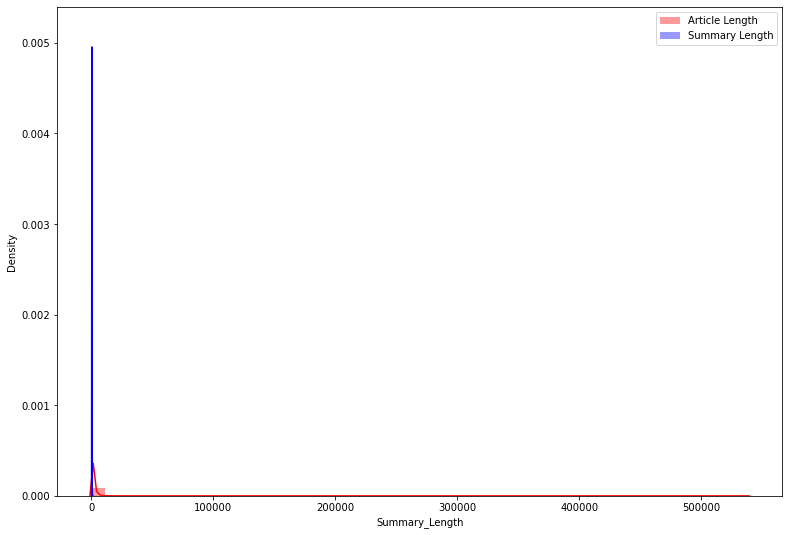

In [15]:
plt.figure(figsize = (13, 9))
sns.distplot(df_train['Article_Length'], color = 'red', label = 'Article Length')
sns.distplot(df_train['Summary_Length'], color = 'blue', label = 'Summary Length')
plt.legend()

#### Examine the distribution of lengths separately

##### Distribution Plot for Article Length as well as Statistical Measures

/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Article_Length', ylabel='Density'>

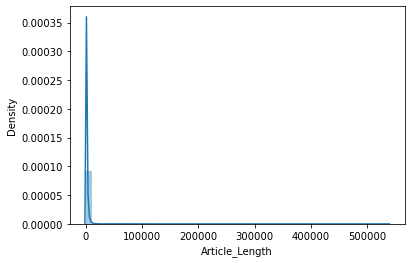

In [16]:
sns.distplot(df_train['Article_Length'])

In [17]:
df_train['Article_Length'].describe()

count     44972.000000
mean       2171.902161
std        3694.544933
min          27.000000
25%         975.000000
50%        1600.000000
75%        2554.000000
max      538078.000000
Name: Article_Length, dtype: float64

In [18]:
np.percentile(df_train['Article_Length'], 90)

4097.800000000003

##### Distribution Plot for Summary Length as well as Statistical Measures

/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Summary_Length', ylabel='Density'>

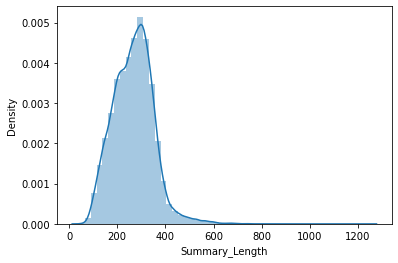

In [19]:
sns.distplot(df_train['Summary_Length'])

In [20]:
df_train['Summary_Length'].describe()

count    44972.000000
mean       266.942320
std         83.695479
min         42.000000
25%        207.000000
50%        269.000000
75%        320.000000
max       1247.000000
Name: Summary_Length, dtype: float64

In [21]:
np.percentile(df_train['Summary_Length'], 90)

362.0

### Text Preprocessing

In [44]:
contraction_dict = {"ain't": "is not", " aint ": "is not", "aren't": "are not", " arent ": "are not", " cant ": " cannot ", "can't": "cannot",
                    "'cause": "because", "could've": "could have", "couldn't": "could not", "couldnt": "could not", "didn't": "did not",
                    "didnt": "did not", " dint ": "did not", "doesn't": "does not", "doesnt": "does not", "don't": "do not", " dont ": " do not ", "hadn't": "had not",
                    "hadnt": "had not", "hasn't": "has not", "hasnt": "has not", "havent": "have not", "haven't": "have not", 
                    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", 
                    "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                    "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                    "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                    "shan't": "shall not", "sha'n't": "shall not","shant": "shall not", "shan't've": "shall not have", "she'd": "she would",
                    "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                    "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                    "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
                    "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
                    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've":
                    "we have", "weren't": "were not", "werent": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                    "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "wont": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                    "y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
                    " ie ": "that is", "i.e.": "that is", "Cc": "Carbon copy", " cc ": " carbon copy ", 
                    "TOR": "Terms of Reference", 'eg.': 'example', 'MoU': 'Memorandum of Understanding', 'MoUs': 'Memorandums of Understanding',
                    'MoM': 'Manufacturing Operations Management', "It's": "It is", "m / h": "metres per hour"
                    # 'ime': 'ime', 'ites': 'ites', 'ile': 'ile', 'ide': 'ide', 'ime!': 'ime!', 'ise': 'ise', 'ike': 'ike', 'ife': 'ife',
                    # 'ine.': 'ine.', 'ite': 'ite', 'ines': 'ines', 'iced': 'iced', 'ine': 'ine', 'ive ': 'ive ', 'ime ': 'ime', 'ile ': 'ile',
                    # 'ide ': 'ide', 'ise ': 'ise ', 'ive-':'ive-', 'ives': 'ives', 'ike ': 'ike ', 'ife ': 'ife ', 'ite ': 'ite ', 'ine ': 'ine ',
                    # 'idea': 'idea', 'imes': 'imes', 'ide.': 'ide.', 'ite,': 'ite,', 'ice ': 'ice ', 'iden': 'iden', 'ice,': 'ice,', 'ise,': 'ise,',
                    # 'inen'
                    }

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        if match.group(0) not in contractions.keys():
            return match.group(0)
        else:
            return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling',
                'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2',
                'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What',
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much',
                'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis',
                'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018',
                'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp',
                'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization',
                'beklieve': 'believe', 'e-mail': 'email', 'p2p': 'peer to peer', 'up-to': 'upto', 'revenue-driven': 'revenue-driven',
                'decision-makers': 'decision makers', 'Tvs': 'TVs', 'elswhere': 'elsewhere', 'traanslate': 'translate', 'oeder': 'order',
                'up-to-date': 'up to date', 'win win': 'win-win', 'in-charge': 'in charge', 'invoincing': 'invoicing', 'discus': 'discuss',
                'oraganize': 'organize', 'standsards': 'standards', 'Assuarance': 'Assurance','enterpreneural': 'enterpreneurial',
                'Geo-politics': 'Geopolitics', 'estblish': 'establish', 'tought': 'taught', 'proffesionally': 'professionally',
                'breifings': 'briefings', 'uodated': 'updated', 'hanlde': 'handle', 'tought': 'taught', 'instalment': 'installment',
                'indepth': 'in depth', 'compamy': 'company', 'learge': 'large', 'aperson': 'a person', 'a pproach': 'approach',
                'bein': 'being', ' eg ': ' eg. ', 'asses': 'assess', ' nee ': ' new ', 'organiszed': 'organized', 'inorder': 'in order', 
                'Incase': 'In case', 're-usable': 'reusable', 'eductae':'educate', 'begining': 'beginning', 'reserach': 'research',
                'indentify': 'identify', 'belef': 'belief', 'persistant': 'persistent', 'intouch': 'in touch', 'negotaite': 'negotiate',
                'relaevant': 'relevant', 'hnest': 'honest', 'up-todate': 'up to date', 'stafd': 'staff', 'tabke': 'table', 
                'aforeign': 'a foreign', 'organizagion': 'organisation', 'realible': 'reliable', 'Cordination': 'Coordination', 
                'seam,ess': 'seamless', 'neccesary': 'necessary', ' yo ': 'you', 'logistica': 'logistics', 'sanitzation': 'sanitization',
                'organse': 'organise', 'aftter': 'after', 'traning': 'training', 'successfull': 'successful', 'consignmet': 'consignment',
                'intrdue': 'introduce', 'prodcut': 'product', 'knwlegde': 'knowledge', 'roganizational': 'organisational', 'co-ordinate': 'coordinate',
                'organizing': 'organising', 'diffrent': 'different', 'businnes': 'business', 'buisness': 'business', 'ecuses': 'excuses', 'financinal': 'financial',
                'objecives': 'objectives', 'succesful': 'successful', 'fertilixzers': 'fertilizers', 'trianing': 'training',
                'updatea': 'updated', 'someof': 'some of', 'boarder': 'border', 'deliveires': 'deliveries', 'exsisting': 'existing',
                'elaviating': 'alleviating', 'excell': 'excel', 'goole': 'google', 'feedbackj': 'feedback', 'occasionaly': 'occassionally',
                'parametres': 'parameters', 'sahre': 'share', 'aslo': 'also', 'emmediately': 'immediately', 'emmediate': 'immediate',
                'prouect': 'product', 'quicke': 'quicker', 'termininal': 'terminal', 'aquick': 'a quick', 'conviencing': 'convincing',
                'convience': 'convince', 'skillsi': 'skills', 'cordinated': 'coordinated', 'contriited': 'contributed', 'feilds': 'fields',
                ' di ': 'did', 'incase': 'in case', 'bt': 'but', 'recollocet': 'reallocate', 'hoime': 'home', ' agri ': 'agriculture',
                'studdies': 'studies', 'troble': 'trouble', 'govrmnet': 'government', 'referencde': 'referenced', 'approva': 'approval',
                'Iwas': 'I was', 'startegic': 'strategic', 'suppprting': 'supporting', 'assosiation': 'association', 'thier': 'their', 
                ' inkind ': ' in kind ', 'discusss': 'discuss'}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)

def replace_typical_misspell(text):
    def replace(match):
        if match.group(0) not in mispellings.keys():
            return match.group(0)
        else:
            return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

def replace_utf8_encodings(free_text):
    ft = re.sub(r'â€™', "'", free_text)
    ft = re.sub(r'â€“', "-", ft)
    ft = re.sub(r'â€˜', "'", ft)
    ft = re.sub(r'â€¦', "…", ft)
    ft = re.sub(r'â€œ', '“', ft)
    ft = re.sub(r'Â£', '£', ft)
    ft = re.sub(r'â€¢', '-', ft)
    return ft    

# sc = SpellChecker()
# def replace_other_misspells(text):
#     tokens = wordpunct_tokenize(text)
#     # Possibly prevent NEs from being judged as wrongly spelled
#     needed_tokens = [token for token in tokens if not token[0].isupper() and token not in string.punctuation]
#     print(needed_tokens)
#     misspelled = sc.unknown(needed_tokens)
#     print(misspelled)
#     if misspelled != set():
#         for token in misspelled:
#             correct = sc.correction(token)
#             print(correct)
#             try:
#                 text = re.sub(token, correct, text)
#             except: pass
#     return text

def preprocess_text(free_text):
    # remove non-word characters    
    ft = free_text.strip()
    ft = re.sub('\x01', '', ft)
    ft = re.sub('\xa0', '', ft)
    ft = replace_utf8_encodings(ft)
    ft = re.sub(r'\n{2}', '.', ft)
    ft = re.sub('&rsquo;', "'", ft)
    if bool(re.search(r'[@â€�™Âœ“ï§¬ž¢¶±ª–ƒÃ˜Ë„ðŸ˜ãƒ»†ðŒï˜]', ft)):
        ft = re.sub(r'[@â€�™Âœ“ï§¬ž¢¶±ª–ƒÃ˜Ë„ðŸ˜ãƒ»†ðŒï˜]', '', ft)
#     ft = re.sub(r'\s\.{2,6}(\s|$)', ' ', ft)
#     ft = re.sub(r"([a-zA-Z])([\.,/:;!?])", r'\1 \2', ft)
    ft = re.sub(r"(['])(\.)", r"\1 \2", ft)
    ft = re.sub(r"(\.)(['])", r"\1 \2", ft)
    ft = re.sub(r'(["])(\.)', r"\1 \2", ft)
    ft = re.sub(r'(\.)(["])', r"\1 \2", ft)
#     ft = re.sub(r'([\.,/:;!?])([a-zA-Z])', r'\1 \2', ft)
    ft = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', ft)
    ft = re.sub(r'(\w)(,)(\w)', r'\1 \2 \3', ft)
    # get rid of 2 or more 
#     ft = re.sub(r'\s\.{2,}\s', ' ', ft)
    ft = re.sub(r'([a-zA-Z0-9#])(!)', r'\1 \2', ft)
    ft = replace_contractions(ft)
    ft = replace_typical_misspell(ft)
    # ft = replace_other_misspells(ft)
    if bool(re.search(r'\d', ft)):
        ft = re.sub(r'([0-9]+)(\.)', r'\1', ft)
        ft = re.sub(r'([0-9]+)(\))', r'\1', ft)
        # x = re.sub('$[0-9]+(\.)', '\1 \2', ft)
        # x = re.sub('$[0-9]+(\))', '\1 \2', ft)
#         ft = re.sub('[0-9]{5,}', '#####', ft)
#         ft = re.sub('[0-9]{4}', '####', ft)
#         ft = re.sub('[0-9]{3}', '###', ft)
#         ft = re.sub('[0-9]{2}', '##', ft)
    return ft


#### Test the Text Preprocessing Module

In [45]:
df_train['document'].values[2]

"In Brief \n  \n San Francisco named top U.S. city \n  \n San Francisco has done it again. For the 17th straight year, the City by the Bay was named best U.S. city to visit in the Readers' Choice Awards from Conde Nast Traveler magazine. \n  \n Best cities, hotels, resorts, airlines and more are selected based on a survey of 25,000 readers. Results are revealed in the November issue. \n  \n San Francisco edged out Charleston, S.C., for the top spot among U.S. cities. Other top cities include Ubud, Bali, for Asia; Vancouver, Canada, for the Americas; and Florence, Italy, for Europe. \n  \n Four Seasons Tented Camp Golden Triangle in Chiang Rai, Thailand, was No. 1 on the Top 100 list of hotels, resorts and cruise lines. Kenwood Inn and Spa in Sonoma was the highest ranking California property at No. 36. \n  \n Other top award recipients included Celebrity for mega cruise line, Hertz for rental car, Virgin for North American airline and Singapore for global airline. \n  \n Airport update

In [46]:
print(df_train['document'].values[2])

In Brief 
  
 San Francisco named top U.S. city 
  
 San Francisco has done it again. For the 17th straight year, the City by the Bay was named best U.S. city to visit in the Readers' Choice Awards from Conde Nast Traveler magazine. 
  
 Best cities, hotels, resorts, airlines and more are selected based on a survey of 25,000 readers. Results are revealed in the November issue. 
  
 San Francisco edged out Charleston, S.C., for the top spot among U.S. cities. Other top cities include Ubud, Bali, for Asia; Vancouver, Canada, for the Americas; and Florence, Italy, for Europe. 
  
 Four Seasons Tented Camp Golden Triangle in Chiang Rai, Thailand, was No. 1 on the Top 100 list of hotels, resorts and cruise lines. Kenwood Inn and Spa in Sonoma was the highest ranking California property at No. 36. 
  
 Other top award recipients included Celebrity for mega cruise line, Hertz for rental car, Virgin for North American airline and Singapore for global airline. 
  
 Airport updates 
  
 San Jose

In [47]:
preprocess_text(df_train['document'].values[2])

"In Brief \n  \n San Francisco named top U.S. city \n  \n San Francisco has done it again. For the 17 th straight year, the City by the Bay was named best U.S. city to visit in the Readers' Choice Awards from Conde Nast Traveler magazine. \n  \n Best cities, hotels, resorts, airlines and more are selected based on a survey of 25 , 000 readers. Results are revealed in the November issue. \n  \n San Francisco edged out Charleston, S.C., for the top spot among U.S. cities. Other top cities include Ubud, Bali, for Asia; Vancouver, Canada, for the Americas; and Florence, Italy, for Europe. \n  \n Four Seasons Tented Camp Golden Triangle in Chiang Rai, Thailand, was No. 1 on the Top 100 list of hotels, resorts and cruise lines. Kenwood Inn and Spa in Sonoma was the highest ranking California property at No. 36 \n  \n Other top award recipients included Celebrity for mega cruise line, Hertz for rental car, Virgin for North American airline and Singapore for global airline. \n  \n Airport upda

In [48]:
print(preprocess_text(df_train['document'].values[2]))

In Brief 
  
 San Francisco named top U.S. city 
  
 San Francisco has done it again. For the 17 th straight year, the City by the Bay was named best U.S. city to visit in the Readers' Choice Awards from Conde Nast Traveler magazine. 
  
 Best cities, hotels, resorts, airlines and more are selected based on a survey of 25 , 000 readers. Results are revealed in the November issue. 
  
 San Francisco edged out Charleston, S.C., for the top spot among U.S. cities. Other top cities include Ubud, Bali, for Asia; Vancouver, Canada, for the Americas; and Florence, Italy, for Europe. 
  
 Four Seasons Tented Camp Golden Triangle in Chiang Rai, Thailand, was No. 1 on the Top 100 list of hotels, resorts and cruise lines. Kenwood Inn and Spa in Sonoma was the highest ranking California property at No. 36 
  
 Other top award recipients included Celebrity for mega cruise line, Hertz for rental car, Virgin for North American airline and Singapore for global airline. 
  
 Airport updates 
  
 San Jo

In [49]:
df_train['preprocessed_articles'] = df_train['document'].progress_apply(preprocess_text)
df_train['preprocessed_summaries'] = df_train['summary'].progress_apply(preprocess_text)
df_val['preprocessed_articles'] = df_val['document'].progress_apply(preprocess_text)
df_val['preprocessed_summaries'] = df_val['summary'].progress_apply(preprocess_text)

100%|██████████████████████████████████████| 5622/5622 [00:14<00:00, 386.39it/s]


In [50]:
df_train['preprocessed_summaries'] = df_train['preprocessed_summaries'].apply(lambda x: '_START_ ' + x + ' _END_')
df_val['preprocessed_summaries'] = df_val['preprocessed_summaries'].apply(lambda x: '_START_ ' + x + ' _END_')

### Declare and Initialize separate Keras Tokenizers for Article and Summary

#### Text Tokenizer for Articles

In [51]:
article_tk = Tokenizer(filters = '')
article_tk.fit_on_texts(df_train['preprocessed_articles'].tolist() + df_val['preprocessed_articles'].tolist())

#### Text Tokenizer for Summaries

In [52]:
summary_tk = Tokenizer(filters = '')
summary_tk.fit_on_texts(df_train['preprocessed_summaries'].tolist() + df_val['preprocessed_summaries'].tolist())

### Extract GLoVe Embeddings

In [53]:
embed_size = 300
embedding_path = 'glove.840B.300d.txt'

In [54]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
    
# return word and its corresponding 300 dimensional vector as a dictionary
embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore'))

In [55]:
# Create a 2D numpy array of dimensions 840B x 300D using only the vector values of words 
all_embs = np.stack(embedding_index.values())

/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3364: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [56]:
# Extract mean and standard deviation of vector values to be used for replacing missing values
emb_mean, emb_std = all_embs.mean(), all_embs.std()

#### Generate Separate Embedding Matrices for Articles and Summaries to provide as Inputs to Encoder and Decoder respectively

##### Embeddings for Articles 

In [57]:
# Create vocabulary using tokenizer's assigned indices to words
article_word_index = article_tk.word_index

In [58]:
# Decide the maximum number of words to be used from the vocabulary
article_vocab_size = len(article_word_index) + 1
article_vocab_size

1411217

In [59]:
# generate a 2D matrix that comprises of values from a normal random distribution generated using Mean and Standard Deviation of the vector values
# obtained from a previous step.
# We can also initialize the entire matrix with zero values
# Matrix Dimensions = (Max Features + 1) words x 300 Dimensions
article_embedding_matrix = np.random.normal(emb_mean, emb_std, (article_vocab_size, embed_size))

In [60]:
# Replace the row with index 'i' of the mebedding matrix with the vector of the word assigned value 'i' in the word index
for word, i in article_word_index.items():
    try:
        embedding_vector = embedding_index.get(word)
        article_embedding_matrix[i] = embedding_vector
    except: pass

In [61]:
article_embedding_matrix.shape

(1411217, 300)

##### Embeddings for Summaries

In [62]:
# Create vocabulary using tokenizer's assigned indices to words
summary_word_index = summary_tk.word_index

In [63]:
# Decide the maximum number of words to be used from the vocabulary
summary_vocab_size = len(summary_word_index) + 1
summary_vocab_size

372092

In [64]:
# generate a 2D matrix that comprises of values from a normal random distribution generated using Mean and Standard Deviation of the vector values
# obtained from a previous step.
# We can also initialize the entire matrix with zero values
# Matrix Dimensions = (Max Features + 1) words x 300 Dimensions
summary_embedding_matrix = np.random.normal(emb_mean, emb_std, (summary_vocab_size, embed_size))

In [65]:
# Replace the row with index 'i' of the mebedding matrix with the vector of the word assigned value 'i' in the word index
for word, i in summary_word_index.items():
    try:
        embedding_vector = embedding_index.get(word)
        summary_embedding_matrix[i] = embedding_vector
    except: pass

In [66]:
summary_embedding_matrix.shape

(372092, 300)

### Prepare Data for Training Phase

#### Declare Maximum Values for Article Length and Summary Length & Batch Size for Training

In [67]:
maxlen_article = 4100
maxlen_summary = 365
latent_dim = 300
batch_size = 64

#### Convert Text Data into Sequences of Fixed Length 

##### ***Use Post Padding***

###### Training Data

In [68]:
train_article_sequences = article_tk.texts_to_sequences(df_train['preprocessed_articles'].tolist())
train_summary_sequences = summary_tk.texts_to_sequences(df_train['preprocessed_summaries'].tolist())

In [69]:
X_train = pad_sequences(train_article_sequences, maxlen = maxlen_article, padding = 'post')
y_train = pad_sequences(train_summary_sequences, maxlen = maxlen_summary, padding = 'post')

In [70]:
X_train.shape

(44972, 4100)

In [71]:
y_train.shape

(44972, 365)

###### Validation Data

In [72]:
validation_article_sequences = article_tk.texts_to_sequences(df_val['preprocessed_articles'].tolist())
validation_summary_sequences = summary_tk.texts_to_sequences(df_val['preprocessed_summaries'].tolist())

In [73]:
X_val = pad_sequences(validation_article_sequences, maxlen = maxlen_article, padding = 'post')
y_val = pad_sequences(validation_summary_sequences, maxlen = maxlen_summary, padding = 'post')

In [74]:
X_val.shape

(5622, 4100)

In [75]:
y_val.shape

(5622, 365)

### Check Data Types

In [76]:
X_train.dtype

dtype('int32')

In [77]:
X_val.dtype

dtype('int32')

In [78]:
y_train.dtype

dtype('int32')

In [79]:
y_val.dtype

dtype('int32')

### Generate Model

#### Custom Attention Mechanism

In [89]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

##### ***Note: GLoVe Embeddings are pretrained, hence the trainable parameter is set to false***

In [90]:
# Encoder 
encoder_inputs = Input(shape = (maxlen_article,))
enc_emb = Embedding(article_vocab_size, embed_size, input_length = maxlen_article, weights = [article_embedding_matrix], trainable = False)(encoder_inputs) 

In [91]:
# LSTM 1 
encoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True) 
encoder_output1, state_h, state_c = encoder_lstm(enc_emb) 

# LSTM 2 
encoder_lstm1 = LSTM(latent_dim, return_sequences = True, return_state = True) 
encoder_output2, state_h1, state_c1 = encoder_lstm1(encoder_output1) 

# LSTM 3 
encoder_lstm2 = LSTM(latent_dim, return_sequences = True, return_state = True) 
encoder_outputs, state_h2, state_c2 = encoder_lstm2(encoder_output2) 

In [92]:
# Set up the decoder. 
decoder_inputs = Input(shape = (None,))
dec_emb_layer = Embedding(summary_vocab_size, embed_size, input_length = maxlen_summary, weights = [summary_embedding_matrix], trainable = False ) 
dec_emb = dec_emb_layer(decoder_inputs) 

In [93]:
# Initialize a decoder LSTM using final encoder LSTM's output states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True) 
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state = [state_h2, state_c2]) 

In [95]:
# Attention Layer - Use BahdanauAttention for seq2seq tasks as standard Attention Layer raises a concatenation error 
attention_layer = AttentionLayer(name = 'attention_layer')
attention_out, attention_states = attention_layer([encoder_outputs, decoder_outputs]) 

The following Variables were used a Lambda layer's call (tf.linalg.matmul_12), but
are not present in its tracked objects:
  <tf.Variable 'attention_layer/W_a:0' shape=(300, 300) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (tf.linalg.matmul_12), but
are not present in its tracked objects:
  <tf.Variable 'attention_layer/W_a:0' shape=(300, 300) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (tf.linalg.matmul_13), but
are not present in its tracked objects:
  <tf.Variable 'attention_layer/V_a:0' shape=(300, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (tf.linalg.matmul_13), but
are not present in its tracked objects:
  <tf.Variable 'attention_layer/V_a:0' shape=(300, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (tf.linalg.matmul_14), but
are not present in its tracked objects:
  <tf.Variable 'attention_layer/W_a:0' shape=(300, 300) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (tf.linalg.matmul_14), but
are not present in its tracked objects:
  <tf.Variable 'attention_layer/W_a:0' shape=(300, 300) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (tf.linalg.matmul_15), but
are not present in its tracked objects:
  <tf.Variable 'attention_layer/V_a:0' shape=(300, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (tf.linalg.matmul_15), but
are not present in its tracked objects:
  <tf.Variable 'attention_layer/V_a:0' shape=(300, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.

In [87]:
# Concat attention output and decoder LSTM output columnwise
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_out])

NameError: name 'attention_out' is not defined

In [96]:
# Output Layer - Dense
decoder_dense = TimeDistributed(Dense(summary_vocab_size, activation = 'softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input)

NameError: name 'decoder_concat_input' is not defined

In [86]:
# Define & Compile the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4100)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 4100, 300)    423365100   input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 4100, 300),  721200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#### Define an EarlyStopping Callback

In [78]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1)

#### Verify Input Shapes

In [79]:
y_train[:, :-1].shape

(2000, 199)

In [80]:
y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:].shape

(2000, 199, 1)

In [81]:
y_val[:, :-1].shape

(225, 199)

In [82]:
y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:].shape

(225, 199, 1)

### Train the Model

In [85]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:], epochs = 10, callbacks=[es], batch_size = batch_size, validation_data = ([X_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10


ResourceExhaustedError: ignored

In [ ]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend()

### Build vocabulary to convert index to word for the target and source vocabulary  

In [ ]:
reverse_summary_word_index = summary_tk.index_word
reverse_article_word_index = article_tk.index_word 

### Set up Inference Mechanism

In [ ]:
# encoder inference
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])

In [ ]:
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(embed_size,))
decoder_state_input_c = Input(shape=(embed_size,))
decoder_hidden_state_input = Input(shape=(maxlen_article, embed_size))

In [ ]:
# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

In [ ]:
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = [decoder_state_input_h, decoder_state_input_c])

In [ ]:
#attention inference
attention_out_inference = attention_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inference_concat = Concatenate(axis=-1, name = 'concat')([decoder_outputs2, attention_out_inference], 1)

In [ ]:
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inference_concat)

In [ ]:
# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

### Define a function to implement the Inference Process

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = summary_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_summary_word_index[sampled_token_index]

        if(sampled_token != 'end'):
            decoded_sentence += ' ' + sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

### Define a function to convert an Integer Sequence into a Word Sequence

In [ ]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
      if((i != 0 and i != summary_word_index['start']) and i != summary_word_index['end']):
        newString += reverse_summary_word_index[i] + ' '
    return newString

def seq2article(input_seq):
    newString = ''
    for i in input_seq:
      if(i != 0):
        newString += reverse_article_word_index[i] + ' '
    return newString

### Obtain Summaries for the Validation Data

In [ ]:
for i in range(len(X_val)):
  print("Article: {}".format(seq2article(X_val[i])))
  print("Original summary: {}".format(seq2summary(y_val[i])))
  print("Predicted summary: {}".format(decode_sequence(X_val[i].reshape(1, maxlen_article))))
  print("\n")

NameError: ignored

### Test on an Extraneous Response

In [ ]:
content = open('business_article.txt').read()
content

"While erratic investor behaviour is well-known and documented when markets nosedive, it&rsquo;s not much different when the opposite happens.\n\nWhen markets trade at record highs, rational and logic take a backseat, and to make quick gains, investors end up committing certain mistakes they rue later. So, what are the things you should avoid in such a scenario? Let&rsquo;s find out.\n\nAvoid Investing in Bulk\n\nJumping onto the bull bandwagon, retail investors often end up investing in bulk when markets are trading at a peak. This must be avoided at all costs. Instead, they should invest in a staggered manner, diversifying their investments across asset classes.\n\nIf bulk investments are to be made, balanced advantage funds can prove to be a good bet as they dynamically adjust the equity and debt component as per prevailing market valuations. These funds lower equity exposure during market highs to prevent losses and vice versa.\n\nIn a bid to earn profits in the shortest possible t

In [ ]:
input = preprocess_text(content)
input

"While erratic investor behaviour is well-known and documented when markets nosedive , it is not much different when the opposite happens When markets trade at record highs , rational and logic take a backseat , and to make quick gains , investors end up committing certain mistakes they rue later . So , what are the things you should avoid in such a scenario ? Let's find out Avoid Investing in Bulk . Jumping onto the bull bandwagon , retail investors often end up investing in bulk when markets are trading at a peak . This must be avoided at all costs . Instead , they should invest in a staggered manner , diversifying their investments across asset classess If bulk investments are to be made , balanced advantage funds can prove to be a good bet as they dynamically adjust the equity and debut component as per prevailing market valuations . These funds lower equity exposure during market highs to prevent losses and vice versa In a bid to earn profits in the shortest possible time , invest